# 제9장 자동채색

****공통 모듈 읽어들이기****

In [1]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

**예제 코드9.1:데이터 불러오기**

In [2]:
data_path = 'img/colorize'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sample = len(data_lists) - val_n_sample - test_n_sample

val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample:train_n_sample + val_n_sample + test_n_sample]

In [3]:
print(len(train_lists), len(val_lists), len(test_lists))

23464 2932 2932


**예제 코드9.2 전처리 : 「RGB」를 「LAB」로 변환**

LAB : L (밝기) 정보로부터 AB (색상)을 추론.

In [4]:
import cv2   # pip install opencv-python

img_size = 224
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

def lab2rgb(lab):
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def get_lab_from_data_list(data_list):
    x_lab = []
    for f in data_list:
        rgb = img_to_array(
            load_img(
                f, 
                target_size=(img_size, img_size)
            )
        ).astype(np.uint8)
        lab = rgb2lab(rgb)
        x_lab.append(lab)
    return np.stack(x_lab)

**예제 코드9.3:모델 구축**

In [5]:
from tensorflow.python.keras.layers import Conv2DTranspose

# input channel  = 1  (L)
# output channel = 2  (AB)

autoencoder = Sequential()

# Encoder
# MaxPooling2D 사용하지 않고 stride 2*2 사용
autoencoder.add(Conv2D(32, (3, 3), (1, 1), activation='relu', padding='same', input_shape=(224, 224, 1)))
autoencoder.add(Conv2D(64, (3, 3), (2, 2), activation='relu', padding='same'))
autoencoder.add(Conv2D(128,(3, 3), (2, 2), activation='relu', padding='same'))
autoencoder.add(Conv2D(256,(3, 3), (2, 2), activation='relu', padding='same'))

# Decoder
# UpSampling2D 아닌 Conv2DTranspose 사용
autoencoder.add(Conv2DTranspose(128,(3, 3), (2, 2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(64, (3, 3), (2, 2), activation='relu', padding='same'))
autoencoder.add(Conv2DTranspose(32, (3, 3), (2, 2), activation='relu', padding='same'))
autoencoder.add(Conv2D(2, (1, 1), (1, 1), activation='relu', padding='same'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
____

**예제 코드9.4:모델 요약 확인**

In [6]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 224, 224, 32)      1

**예제 코드9.5 생성기 함수 정의**

In [7]:
def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    while True:
        if shuffle:
            np.random.shuffle(data_list)
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i:i + batch_size]
            batch_lab = get_lab_from_data_list(batch_list)
            batch_l = batch_lab[:, :, :, 0:1]
            batch_ab = batch_lab[:, :, :, 1:]
            yield (batch_l, batch_ab)

**예제 코드9.6:학습•검증•평가용 생성기 호출**

In [8]:
batch_size = 30

train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)
val_gen = generator_with_preprocessing(val_lists, batch_size)
test_gen = generator_with_preprocessing(test_lists, batch_size)

train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

ModelCheckpoint라는 콜백을 사용함으로써, 검증용데이터에 대해서 가장 loss가 적은 모델만을 저장합니다
이렇게 함으로써, 검증데이터에 대해서 가장 좋을때의 파라메터로, 예측할 수 있습니다.

※단지, 간단하게 하기위해, 이 Jupyter Notebook에서는 실행하지 않습니다.
좋은 예측모델로 실행하기위해서는, 다음 순서로 진행하세요
1. 예제코드 9.7의 콜백의 주석을 지우고, 에폭수를 증가시킨다（예를들면500、또는3000등）
1. 학습후, 폴더를 확인해서, loss값이 작은 모델의 파라메터 확인(예를들면, '70-258.01.hdf5'와 같은 이름으로 저장되어 있음）  
1. **추가 코드** 의 모델의 파라메터를 확인한 이름으로 변경한 후, 주석을 지우고 loss값이 작은 모델의 파라메터를 불러들여 예측을 한다

In [9]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

valid_ck = ModelCheckpoint('{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [valid_ck]

**예제 코드9.7 모델 학습**

※책에 기재되어 있는 실행방법과 다른점이 있습니다.
Jupyter Notebook에서는, epoch은 3000에서 150으로 변경했고, 콜백은 사용하지 않습니다.
또, 책에 실려있는 결과는, 실제로 콜백을 사용했지만, 여기서는 간단하게 하기위해, 콜백은 사용하지 않습니다.
좀더 좋은 예측모델로 실행하기위해서는, 위의 순서에 따라서 진행하세요

In [10]:
epochs = 30 # 150

autoencoder.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_steps,
    # callbacks=callbacks, # 콜백을 사용할 경우에는 주석 삭제
)

Epoch 1/30
783/783 [==============================] - 228s 291ms/step - loss: 1803.7076 - val_loss: 324.9359
Epoch 2/30
783/783 [==============================] - 224s 287ms/step - loss: 293.3271 - val_loss: 274.0997
Epoch 3/30
783/783 [==============================] - 226s 288ms/step - loss: 280.4943 - val_loss: 276.2928
Epoch 4/30
783/783 [==============================] - 226s 288ms/step - loss: 281.0805 - val_loss: 269.2779
Epoch 5/30
783/783 [==============================] - 225s 288ms/step - loss: 281.7715 - val_loss: 277.2049
Epoch 6/30
783/783 [==============================] - 226s 288ms/step - loss: 284.8960 - val_loss: 391.3584
Epoch 7/30
783/783 [==============================] - 230s 294ms/step - loss: 279.9628 - val_loss: 273.4484
Epoch 8/30
783/783 [==============================] - 225s 287ms/step - loss: 284.6478 - val_loss: 277.3359
Epoch 9/30
783/783 [==============================] - 225s 287ms/step - loss: 285.2189 - val_loss: 274.2903
Epoch 10/30
783/783 [======

**추가 코드** 가장 loss가 적은 모델의 파라메터 불러오기

※단, 단순하게 하기위해, 이 Jupter Notebook에서는 실행하지 않음。

In [11]:
# 콜백을 사용하고있는 경우, loss값이 가장 작은 것(저장된 모델중에서 에폭이 큰것)을 사용
# autoencoder.load_weights('70-258.01.hdf5')

**예제 코드9.8:모델 예측**

In [12]:
preds = autoencoder.predict_generator(test_gen, steps=test_steps, verbose=0)

x_test = []
y_test = []
for i, (l, ab) in enumerate(generator_with_preprocessing(test_lists, batch_size)):
    x_test.append(l)
    y_test.append(ab)
    if i == (test_steps - 1):
        break
        
x_test = np.vstack(x_test)
y_test = np.vstack(y_test)

**예제 코드9.9:후처리 : 예측 결과「AB」를 입력하고 「L」과 결합해서 「RGB」로 변환**

In [13]:
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8)

test_preds_rgb = []
for i in range(test_preds_lab.shape[0]):
    preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])
    test_preds_rgb.append(preds_rgb)
test_preds_rgb = np.stack(test_preds_rgb)

**예제 코드9.10:출력 결과 확인**

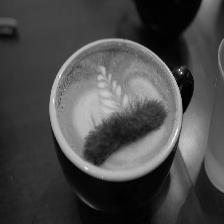

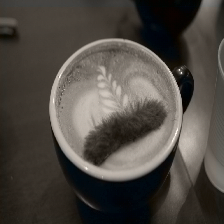

-------------------------


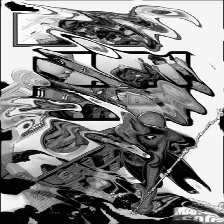

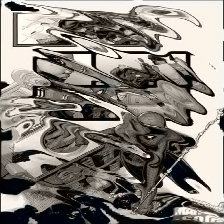

-------------------------


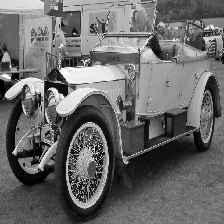

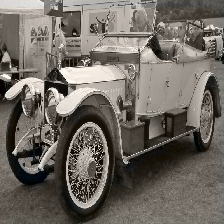

-------------------------


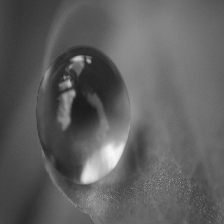

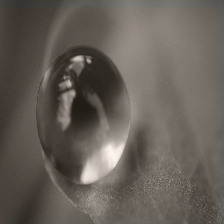

-------------------------


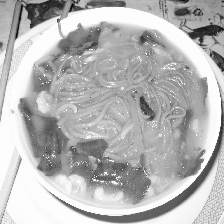

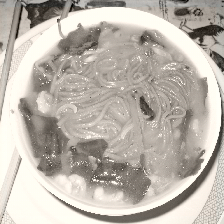

-------------------------


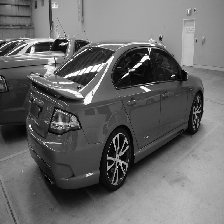

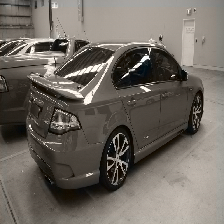

-------------------------


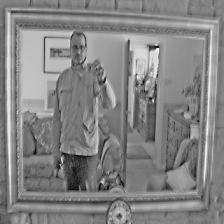

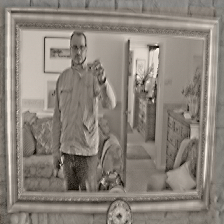

-------------------------


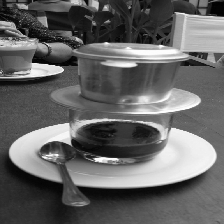

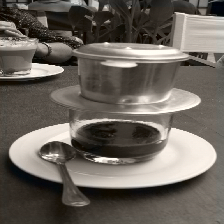

-------------------------


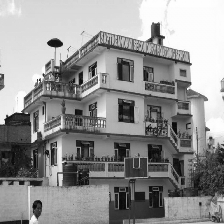

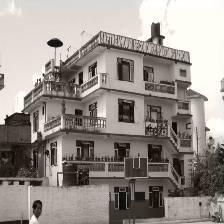

-------------------------


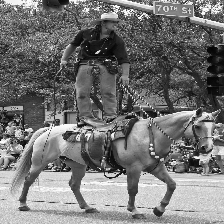

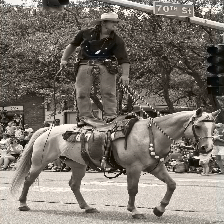

-------------------------


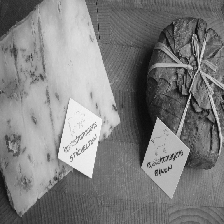

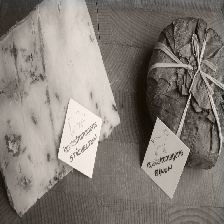

-------------------------


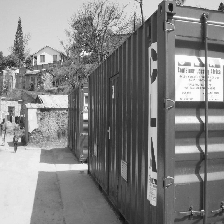

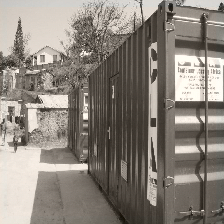

-------------------------


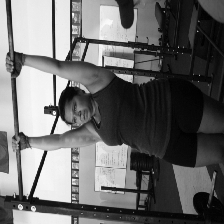

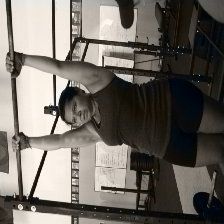

-------------------------


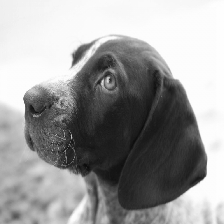

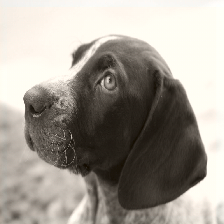

-------------------------


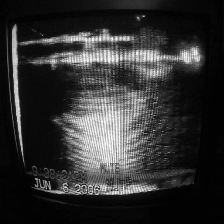

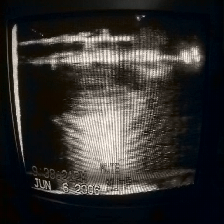

-------------------------


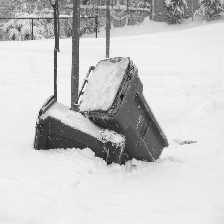

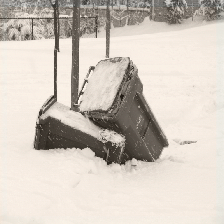

-------------------------


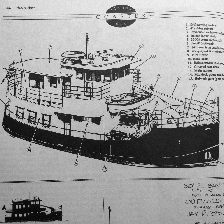

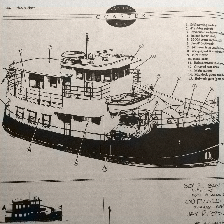

-------------------------


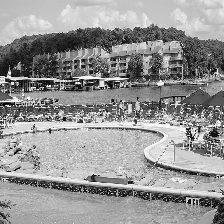

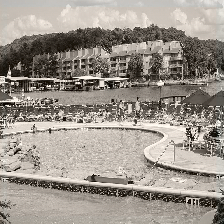

-------------------------


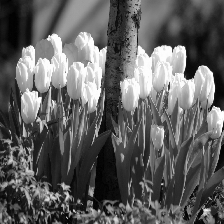

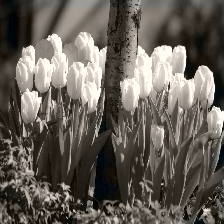

-------------------------


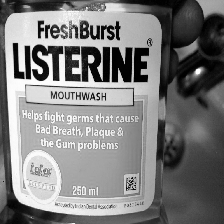

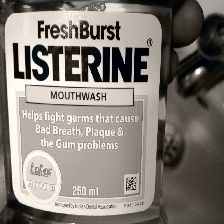

-------------------------


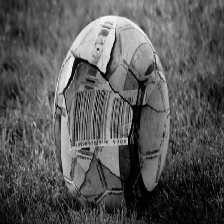

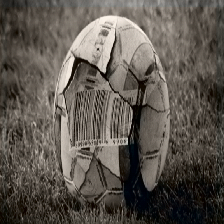

-------------------------


In [14]:
from IPython.display import display_png
from PIL import Image, ImageOps


for i in range(test_preds_rgb.shape[0]):
    gray_image = ImageOps.grayscale(array_to_img(test_preds_rgb[i]))
    display_png(gray_image)
    display_png(array_to_img(test_preds_rgb[i]))
    print('-'*25)
    if i == 20:
        break